# Rosenbrock function

Rosenbrock function (2D):
$$
f(x, y) = (1 - x)^2 + 100 \cdot (y - x^2)^2
$$
- Global minimum: f(x, y) = 0 at (x, y) = (1, 1)
- Non-convex, commonly used to test optimization algorithms



In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import RK45
import adambash
import memgradstep

In [55]:
# Rosenbrock function
def rosenbrock(x, y, a=1, b=100):
    return (a - x)**2 + b*(y - x**2)**2

In [56]:
# Initial point and optimization
x0 = np.array([-1, 2])
# Plot the Rosenbrock function and path
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x, y)
Z = rosenbrock(X, Y)

In [57]:
def prepPlot():
    plt.figure(figsize=(10, 6))
    levels = np.array([i**2 for i in range(20)])
    plt.contour(X, Y, Z, levels=levels, cmap='rainbow')
    plt.plot(1, 1, 'bo', label='Minimum (1,1)')
    plt.plot(-1,2,'co',label='Start')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Rosenbrock Function')
    plt.grid(True)

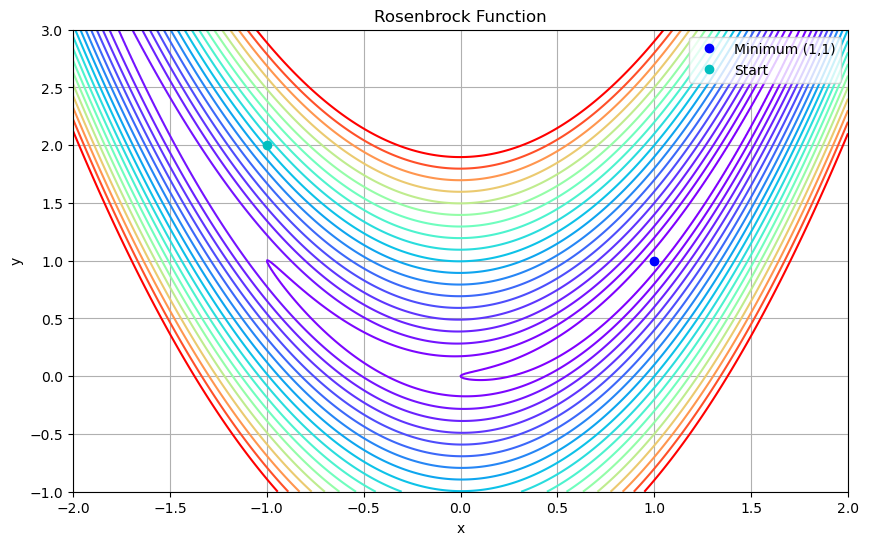

In [58]:
prepPlot()
plt.legend()
plt.show()

In [59]:
# Gradient of the Rosenbrock function
def grad_rosenbrock(xy, a=1, b=100):
    x, y = xy
    dx = -2*(a - x) - 4*b*x*(y - x**2)
    dy = 2*b*(y - x**2)
    return np.array([dx, dy])

In [60]:
# Steepest descent method
def steepest_descent(f_grad, x0, lr=0.001, max_iter=100, tol=1e-6):
    x = x0
    path = [x0.copy()]
    for i in range(max_iter):
        grad = f_grad(x)
        x_new = x - lr * grad
        if np.linalg.norm(x_new) > 20:
            break
        path.append(x_new.copy())
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return np.array(path)

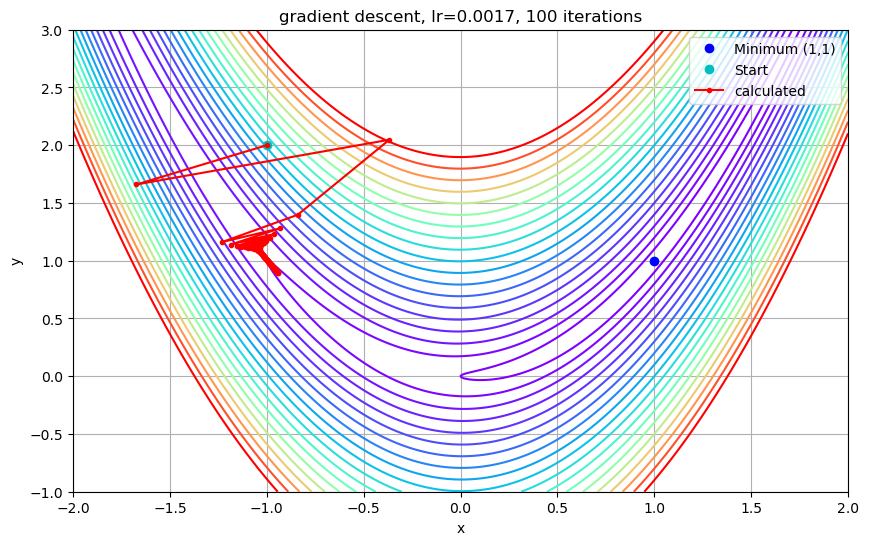

In [61]:
prepPlot()
path = steepest_descent(grad_rosenbrock, x0, lr=0.0017, max_iter=100)
plt.plot(path[:, 0], path[:, 1], 'r.-', label='calculated')
plt.title('gradient descent, lr=0.0017, 100 iterations')
plt.legend()
plt.show()

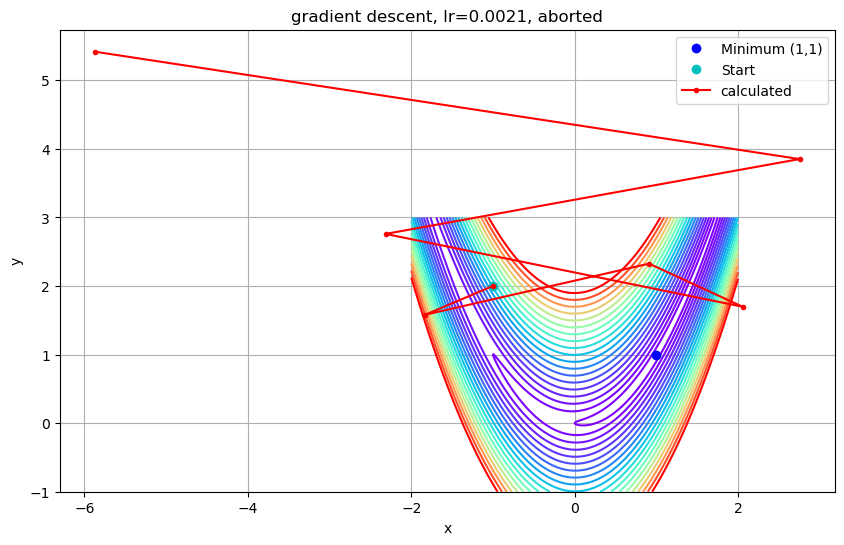

In [62]:
prepPlot()
path = steepest_descent(grad_rosenbrock, x0, lr=0.0021, max_iter=100)
plt.plot(path[:, 0], path[:, 1], 'r.-', label='calculated')
plt.title('gradient descent, lr=0.0021, aborted')
plt.legend()
plt.show()

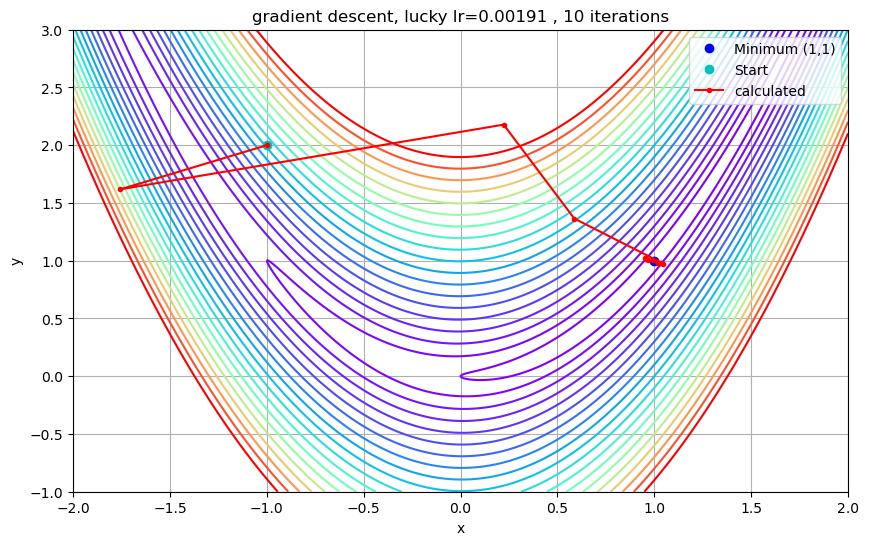

In [63]:
prepPlot()
path = steepest_descent(grad_rosenbrock, x0, lr=0.00191, max_iter=10)
plt.plot(path[:, 0], path[:, 1], 'r.-', label='calculated')
plt.title('gradient descent, lucky lr=0.00191 , 10 iterations')
plt.legend()
plt.show()

# Gradient flow

- need to change x according to the experienced gradient
$$ \dot{z} = g(t, z), z=(x,y) $$

~~~
dx = -2*(a - x) - 4*b*x*(y - x**2)
dy = 2*b*(y - x**2)
~~~
$$ \frac{df(x,y)}{dx} = -2\cdot( 1-x) - 4\cdot 100 \cdot x \cdot(y -x^2) $$
$$ \frac{df(x,y)}{dy} = 2\cdot 100 \cdot(y - x^2) $$
- can find the optimum by integrating to infinity
- integration method Runge-Kutta, with additional time parameter

In [64]:
def gradFlow(t,xy):
    xy_bar = -1 * grad_rosenbrock(xy, 1, 100)
    return xy_bar

In [65]:
def RKLpath(max_iter=10):
    rk45 = RK45(gradFlow,0,x0.copy(), 10,max_step=20000)
    path=[x0.copy()]
    for s in range(max_iter):
        rk45.step()
        path.append(rk45.y.copy())
    return np.array(path)

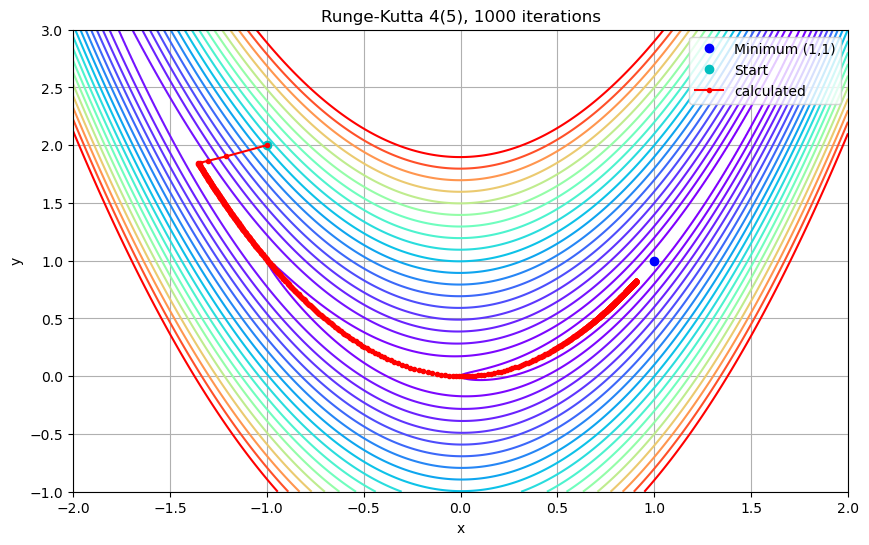

In [66]:
prepPlot()
# Solve using Runge-Kutta 4(5) (RK45)
path = RKLpath(1000)
plt.plot(path[:, 0], path[:, 1], 'r.-', label='calculated')
plt.title("Runge-Kutta 4(5), 1000 iterations")
plt.legend()
plt.show()

## Observations
- Each Runge Kutta step has 4 function evaluations at half stepsize and multiple estimation step.
- tries to find a monotonically decreasing path &rarr; hence has to stay at the bottom of the valley

# Explicit higher order methods
- Adam Bashfort schemes - up to order 6
- considers a polynomial approximation of the gradients
- not bound to decreasing objective values
- constant stepsize (not update size!)

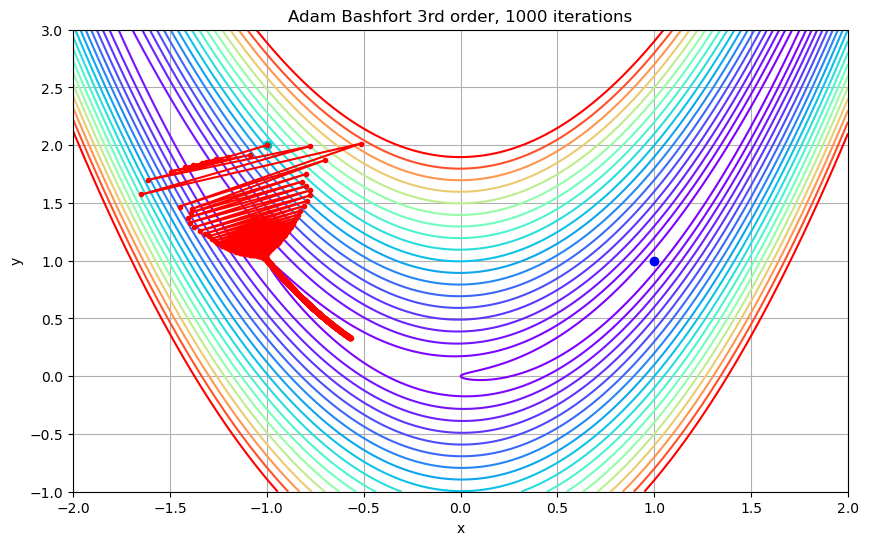

In [67]:
prepPlot()
ab= adambash.AdamBashfort(grad_rosenbrock, x0.copy(),0.0005)
path = ab.iterate(max_order=3, max_iter=1000 )
plt.plot(path[:, 0], path[:, 1], "r.-", label="calculated")
plt.title("Adam Bashfort 3rd order, 1000 iterations")
plt.show()


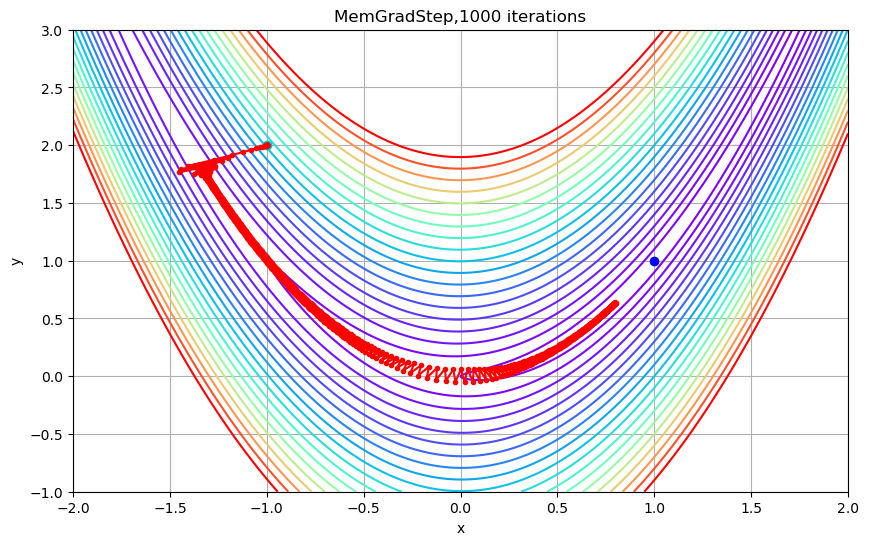

In [68]:
prepPlot()
mgs=memgradstep.MemGradStep(grad_rosenbrock,x0.copy(),decay=0.5,memory=10)
path=mgs.iterate(1000)
plt.plot(path[:,0],path[:,1],"r.-",label="calculated")
plt.title("MemGradStep,1000 iterations")
plt.show()

In [69]:
import adamtest

Text(0.5, 1.0, 'Adam, 1000 iterations')

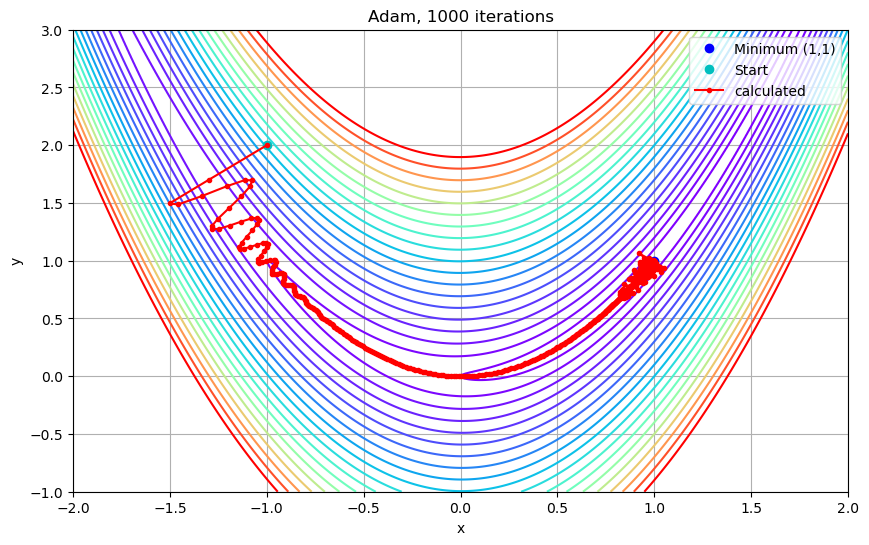

In [70]:
prepPlot()
a = adamtest.Adam(rosenbrock, grad_rosenbrock, x0.copy(), 0.3, 0.9, 0.99, 1e-8)
obs, path, vh, mh = a.iterate(1000)
plt.plot(path[:, 0], path[:, 1], "r.-", label="calculated")
plt.legend()
plt.title("Adam, 1000 iterations")
 

Text(0.5, 1.0, 'Gradients peaks')

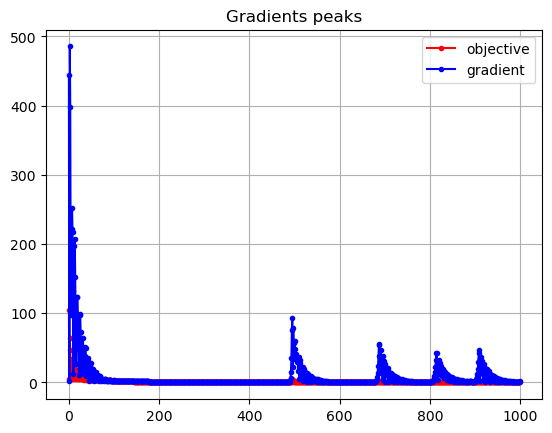

In [73]:
plt.plot(obs[:, 0], "r.-", label="objective")
plt.plot(obs[:, 1], "b.-", label="gradient")
plt.legend()
plt.grid(True)
plt.title("Gradients peaks")